In [1]:
#### Projeto: Desafio ZAP
#### Programa para avaliar performance e outros itens do Modelo escolhido
#### Autor: Rodolfo Bugarin

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
#
# Carregar os Dataframes
#

In [5]:
df_train = pickle.load(open('source-4-ds-train.pickle', 'rb'))

In [6]:
X = pd.read_pickle('df_X_features.pickle')
y = pd.read_pickle('df_y_label.pickle') 

In [7]:
X_train = pd.read_pickle('df_X_train_features.pickle')
X_test = pd.read_pickle('df_X_test_features.pickle') 

In [8]:
y_train = pd.read_pickle('df_y_train_label.pickle')
y_test = pd.read_pickle('df_y_test_label.pickle') 

In [9]:
# Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# Apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Boosting

In [15]:
# Carregar o Modelo
modelo_clf = pd.read_pickle('modelo_clf.pickle')

In [16]:
# Precificação desse modelo
predictions = modelo_clf.predict(X_test)

In [17]:
predictions

array([774162.16074663, 423035.65280711, 453048.9616134 , ...,
       415330.14035303, 953624.40203875, 484522.30871966])

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
print("MSE: %.4f" % mse)
r2 = r2_score(y_test, predictions)
print("R2: %.4f" % r2)

MSE: 101635595220.5466
R2: 0.8997


In [19]:
# Rotina para identificar as features mais importantes do modelo
features = X.columns.tolist()[1:]
features = ['Intercept'] + features
df_features = pd.DataFrame()
df_features ['Features'] = features
df_features ['feature_importances_'] = modelo_clf.feature_importances_

In [20]:
df_features.sort_values(by='feature_importances_',ascending = False).head(n=5)

,Features,feature_importances_
8,usableareas,0.3915
18,Distancia,0.3657
3,pricinginfos_monthlycondofee,0.0751
2,parkingspaces,0.0385
7,totalareas,0.0341


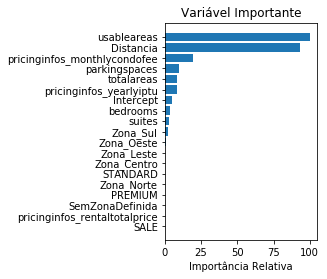

In [21]:
# Plot Importância da feature 
feature_importance = df_features.feature_importances_
# Importância Relativa em relação à vriável mais importante
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
features_series = pd.Series(features) 
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features_series[sorted_idx])
plt.xlabel('Importância Relativa')
plt.title('Variável Importante')
plt.show()

In [22]:
# Rotina para verificar a performance da Estimativa por Bairro
df_predictions = pd.DataFrame(predictions)
df_predictions.rename({0: "Preco_Estimado"}, axis=1, inplace=True)
df_y_test = pd.DataFrame(y_test).reset_index()
df_y_test['Preco_Venda'] = df_y_test.Preco_Venda.astype(float)
df_concat = pd.concat ([df_y_test, df_predictions], axis=1)
df_result = pd.merge(df_concat, df_train, left_on='index', right_index=True, how='left')
df_result['Dif_Preco_Estimado_Venda'] = (df_result['Preco_Estimado'] / df_result['Preco_Venda'])-1
df_bairros = pd.DataFrame(df_result.groupby('address_neighborhood')['Dif_Preco_Estimado_Venda'].mean())
df_bairros ['Dif_Abs'] = df_bairros['Dif_Preco_Estimado_Venda'].abs()

In [23]:
df_concat.head()

,index,Preco_Venda,Preco_Estimado
0,133869,"837,647.0000","774,162.1607"
1,60627,"364,000.0000","423,035.6528"
2,2179,"455,000.0000","453,048.9616"
3,51449,"3,812,412.0000","3,858,679.3423"
4,42086,"5,040,000.0000","5,361,147.3632"


In [24]:
df_bairros.sort_values(by=['Dif_Abs']).head(n=10)

,Dif_Preco_Estimado_Venda,Dif_Abs
address_neighborhood,,
Parque Edu Chaves,-0.0003,0.0003
Pirajussara,0.0007,0.0007
Vila Sonia,-0.0007,0.0007
Pinheiros,-0.0011,0.0011
Chácara Califórnia,-0.0011,0.0011
Planalto Paulista,0.0012,0.0012
Jardim Célia,0.0013,0.0013
Chácara Inglesa,-0.0016,0.0016
Jardim das Perdizes,0.0016,0.0016


In [25]:
df_result[['index', 'Preco_Estimado', 'Preco_Venda', 'pricinginfos_price', 'Dif_Preco_Estimado_Venda', 'address_neighborhood']].head()

,index,Preco_Estimado,Preco_Venda,pricinginfos_price,Dif_Preco_Estimado_Venda,address_neighborhood
0,133869,"774,162.1607","837,647.0000",837647,-0.0758,Pinheiros
1,60627,"423,035.6528","364,000.0000",364000,0.1622,Água Rasa
2,2179,"453,048.9616","455,000.0000",455000,-0.0043,Saúde
3,51449,"3,858,679.3423","3,812,412.0000",3812412,0.0121,Vila Madalena
4,42086,"5,361,147.3632","5,040,000.0000",5040000,0.0637,Alto de Pinheiros
